## Transfer learning with tensorflow part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benifits
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to own own data.

In [ ]:
# Download the data
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the downloaded file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2024-07-07 05:31:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  82.3MB/s    in 2.0s    

2024-07-07 05:31:56 (82.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# How many images in each foler
import os
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent

## Creating data loaders (preparing the data)

We'll use the *ImageDataGenerator* class to lead in our images in batches

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality we can add to our models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments with the TensorBoard callback
* Model checkpoint with the ModelCheckPoint callback
* Stopping a model from training (before it trains too long and overfits) with EarlyStopping callback

In [ ]:
# Create TensorBoard callback (functionized because we need to ccreate a new one for each model)
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

## Creating models using Tensorflow Hub

In the past we used Tensorflow to create our own models layer by layer from scratch.

Now we're going to do similar process, except the majority of our model's layers are going to come from TensorFlow Hub

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

### Creating ResNet

In [ ]:
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [ ]:
# Compile our resnet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

resnet_history = resnet_model.fit(train_data_10_percent, epochs=10,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_data=test_data,
                 validation_steps=len(test_data),
                 callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                        experiment_name="resnet5OV2"
                                                        )])

Saving TensorBoard log files to: tensorflow_hub/resnet5OV2/20240707-053214
Epoch 1/10
24/24 [==============================] - 26s 632ms/step - loss: 1.9691 - accuracy: 0.3587 - val_loss: 1.1575 - val_accuracy: 0.6420
Epoch 2/10
24/24 [==============================] - 11s 469ms/step - loss: 0.8690 - accuracy: 0.7627 - val_loss: 0.8217 - val_accuracy: 0.7408
Epoch 3/10
24/24 [==============================] - 11s 467ms/step - loss: 0.6074 - accuracy: 0.8240 - val_loss: 0.7356 - val_accuracy: 0.7672
Epoch 4/10
24/24 [==============================] - 11s 470ms/step - loss: 0.4740 - accuracy: 0.8733 - val_loss: 0.6974 - val_accuracy: 0.7732
Epoch 5/10
24/24 [==============================] - 11s 484ms/step - loss: 0.3693 - accuracy: 0.9173 - val_loss: 0.6651 - val_accuracy: 0.7836
Epoch 6/10
24/24 [==============================] - 12s 501ms/step - loss: 0.3079 - accuracy: 0.9427 - val_loss: 0.6418 - val_accuracy: 0.7868
Epoch 7/10
24/24 [==============================] - 11s 472ms/step 

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [ ]:
# Plot the validation and training curves
def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel('epochs')
    plt.legend()

    # Plot the accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()

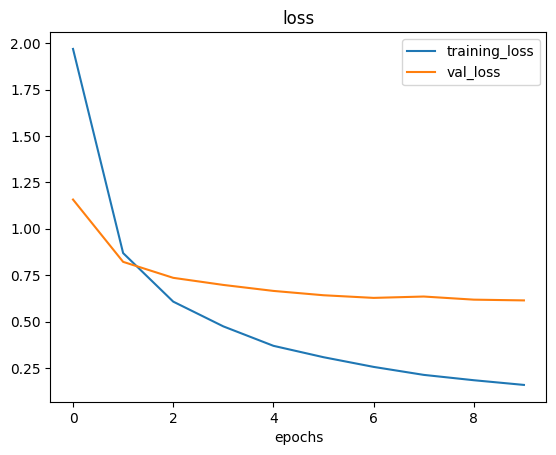

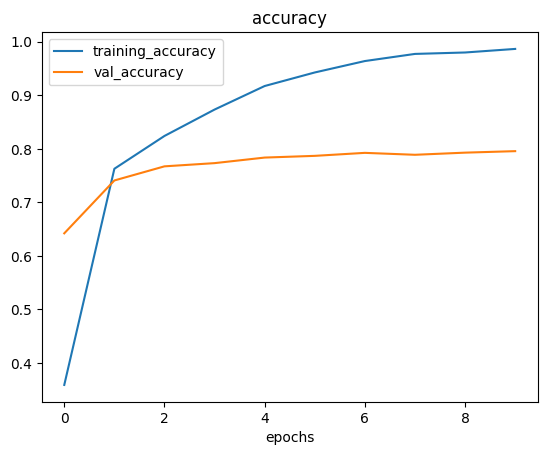

In [ ]:
plot_loss_curves(resnet_history)

In [ ]:
# Creating EfficientNetB0
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_percent.num_classes)

# Compile efficientNet model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs=10,
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     experiment_name="efficientnetb0")])


Saving TensorBoard log files to: tensorflow_hub/efficientnetb0/20240707-053537
Epoch 1/10
24/24 [==============================] - 24s 565ms/step - loss: 1.8558 - accuracy: 0.4400 - val_loss: 1.3079 - val_accuracy: 0.7276
Epoch 2/10
24/24 [==============================] - 10s 434ms/step - loss: 1.0569 - accuracy: 0.7667 - val_loss: 0.8679 - val_accuracy: 0.8180
Epoch 3/10
24/24 [==============================] - 10s 435ms/step - loss: 0.7512 - accuracy: 0.8293 - val_loss: 0.6981 - val_accuracy: 0.8420
Epoch 4/10
24/24 [==============================] - 13s 549ms/step - loss: 0.6072 - accuracy: 0.8560 - val_loss: 0.6108 - val_accuracy: 0.8508
Epoch 5/10
24/24 [==============================] - 10s 436ms/step - loss: 0.5118 - accuracy: 0.8787 - val_loss: 0.5614 - val_accuracy: 0.8620
Epoch 6/10
24/24 [==============================] - 11s 472ms/step - loss: 0.4469 - accuracy: 0.8973 - val_loss: 0.5226 - val_accuracy: 0.8660
Epoch 7/10
24/24 [==============================] - 10s 441ms/s

In [ ]:
efficientnet_model.evaluate(test_data)

79/79 [==============================] - 8s 94ms/step - loss: 0.4454 - accuracy: 0.8760


[0.44539257884025574, 0.8759999871253967]

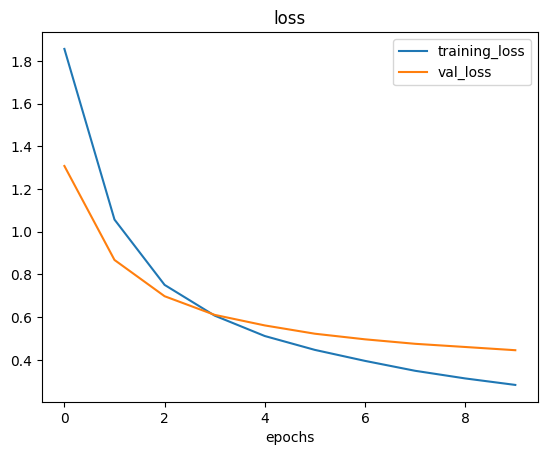

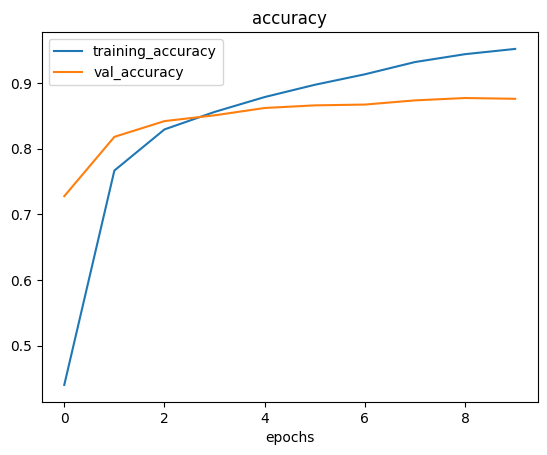

In [ ]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever(eg using ImageNet model on 1000 ImageNet classes, none of our own)
* **"Feature extraction"** transfer learning - use the prelearned patterns of an existing model (eg. EfficientNetB0 trained on ImageNet) and adjust the output layer for our own problem (eg. 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - Use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying (including new output layers)

In [ ]:
# How many layers does our efficientnetb0 feature extractor have?
len(efficientnet_model.layers[0].weights)

309

## Comparing our models in TensorBoard

**Note:** When we upload things to TensorBoard.dev, our experiments are public

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two different TF Hub features extraction model architecture using 10% of the training data" \
  --one_shot

2024-07-07 05:59:31.847599: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 05:59:31.847649: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 05:59:31.848899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 05:59:32.830057: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb